In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import scipy.stats as ss
import time
from numba import njit

warnings.filterwarnings("ignore")

In [2]:
class VarianceReduction:
    def __init__(self, S0, K, r, T, sigma, n, m):
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.sigma = sigma
        self.n = n
        self.m = m
        self.dt = self.T / self.n

    def d1(self, t = 0):
        return ((np.log(self.S0 / self.K) + (self.r + 0.5 * self.sigma ** 2) * (self.T-t))/(self.sigma * np.sqrt(self.T-t)))
    
    def d2(self, t = 0):
        return self.d1(t) - self.sigma * np.sqrt(self.T-t)

    def black_scholes(self, option, position, t = 0):
        if option == 'vanilla':
            if position == 'call':
                return self.S0 * ss.norm.cdf(self.d1(t)) - \
                    self.K * np.exp(-self.r * self.T) * ss.norm.cdf(self.d2(t))
            elif position == 'put':
                return self.K * np.exp(-self.r * self.T) * ss.norm.cdf(-self.d2(t)) - \
                    self.S0 * ss.norm.cdf(-self.d1(t))
        mini = self.S0 # assumption from notes
        maxi = self.S0 # assumption from notes
        if option == 'lookback floating':
            if position == 'call':
                return self.S0 * ss.norm.cdf(self.d1(t)) - mini * np.exp(-self.r * (self.T-t)) * ss.norm.cdf(self.d2(t)) + self.S0 * np.exp(-self.r*(self.T-t)) * self.sigma**2/(2*self.r) * \
                    ((self.S0/mini)**(-2*self.r/self.sigma**2) * ss.norm.cdf(-self.d1(t) + (2*self.r*np.sqrt(self.T-t))/self.sigma) - np.exp(self.r*(self.T-t)) * ss.norm.cdf(-self.d1(t)))
            if position == 'put':
                return maxi * np.exp(-self.r * (self.T - t)) * ss.norm.cdf(-self.d2(t)) - self.S0 * ss.norm.cdf(-self.d1(t)) + self.S0 * np.exp(-self.r*(self.T-t)) * self.sigma**2/(2*self.r) * \
                    (-(self.S0/maxi)**(-2*self.r/self.sigma**2) * ss.norm.cdf(self.d1(t) - (2*self.r*np.sqrt(self.T-t))/self.sigma) + np.exp(self.r*(self.T-t)) * ss.norm.cdf(self.d1(t)))
        if option == 'lookback fixed':
            if position == 'call':
                if self.K > maxi:
                    return self.S0 * ss.norm.cdf(self.d1(t)) - self.K * np.exp(-self.r * (self.T-t)) * ss.norm.cdf(self.d2(t)) + self.S0 * np.exp(-self.r*(self.T-t)) * self.sigma**2/(2*self.r) * \
                        (-(self.S0/self.K)**(-2*self.r/self.sigma**2) * ss.norm.cdf(self.d1(t) - (2*self.r*np.sqrt(self.T-t))/self.sigma) + np.exp(self.r*(self.T-t)) * ss.norm.cdf(self.d1(t)))
                else:
                    return (maxi - self.K) * np.exp(-self.r*(self.T-t)) + self.S0 * ss.norm.cdf(self.d1(t)) - maxi * np.exp(-self.r * (self.T-t)) * ss.norm.cdf(self.d2(t)) + self.S0 * np.exp(-self.r*(self.T-t)) * self.sigma**2/(2*self.r) * \
                        (-(self.S0/maxi)**(-2*self.r/self.sigma**2) * ss.norm.cdf(self.d1(t) - (2*self.r*np.sqrt(self.T-t))/self.sigma) + np.exp(self.r*(self.T-t)) * ss.norm.cdf(self.d1(t)))
            if position == 'put':
                if self.K < mini:
                    return self.K * np.exp(-self.r * (self.T-t)) * ss.norm.cdf(-self.d2(t)) - self.S0 * ss.norm.cdf(-self.d1(t)) + self.S0 * np.exp(-self.r*(self.T-t)) * self.sigma**2/(2*self.r) * \
                        ((self.S0/self.K)**(-2*self.r/self.sigma**2) * ss.norm.cdf(-self.d1(t) + (2*self.r*np.sqrt(self.T-t))/self.sigma) - np.exp(self.r*(self.T-t)) * ss.norm.cdf(-self.d1(t)))
                else:
                    return (self.K - mini) * np.exp(-self.r*(self.T-t)) + mini * np.exp(-self.r * (self.T-t)) * ss.norm.cdf(-self.d2(t)) - self.S0 * ss.norm.cdf(-self.d1(t)) + self.S0 * np.exp(-self.r*(self.T-t)) * self.sigma**2/(2*self.r) * \
                        ((self.S0/mini)**(-2*self.r/self.sigma**2) * ss.norm.cdf(-self.d1(t) + (2*self.r*np.sqrt(self.T-t))/self.sigma) - np.exp(self.r*(self.T-t)) * ss.norm.cdf(-self.d1(t)))
    
    def payoff(self, S, option, position):
        if option == 'vanilla':
            if position == 'call':
                return np.maximum(S[:, -1] - self.K, 0)
            elif position == 'put':
                return np.maximum(self.K - S[:, -1], 0)
        if option == 'lookback floating':
            if position == 'call':
                return S[:, -1] - np.min(S, axis = 1)
            elif position == 'put':
                return np.max(S, axis = 1) - S[:, -1]
        if option == 'lookback fixed':
            if position == 'call':
                return np.maximum(np.max(S, axis = 1) - self.K, 0)
            elif position == 'put':
                return np.maximum(self.K - np.min(S, axis = 1), 0)

    def trajectory_matrix(self, method, scheme, full = False):
        if full == True:
            S = np.zeros((self.m, self.n + 1))
            S[:, 0] = self.S0
            Z_ = np.random.normal(0, 1, (self.m // 2, self.n))
            Z = np.zeros((self.m, self.n))
            Z[:self.m // 2, :] = Z_
            if method == 'AV':
                Z[self.m // 2:, :] = -Z_
            else:
                Z__ = np.random.normal(0, 1, (self.m // 2, self.n))
                Z[self.m // 2:, :] = Z__
            for i in range(1, self.n + 1):
                if scheme == 'euler':
                    S[:, i] = S[:, i-1] * (1 + self.r * self.dt + self.sigma * np.sqrt(self.dt) * Z[:, i-1])
                elif scheme == 'milstein':
                    S[:, i] = S[:, i-1] * (1 + self.r * self.dt + self.sigma * np.sqrt(self.dt) * Z[:, i-1] + \
                                        self.sigma**2/2 * self.dt * (Z[:, i-1]**2 - 1))
        if full == False:
            S = np.zeros((self.m, 2))
            S[:, 0] = self.S0
            Z_ = np.random.normal(0, 1, self.m // 2)
            Z = np.zeros((self.m))
            Z[:self.m // 2] = Z_
            if method == 'AV':
                Z[self.m // 2:] = -Z_
            else:
                Z__ = np.random.normal(0, 1, self.m // 2)
                Z[self.m // 2:] = Z__
            if scheme == 'euler':
                S[:, -1] = self.S0 * np.exp((self.r - self.sigma**2/2) * self.T + self.sigma * np.sqrt(self.T) * Z)
            elif scheme == 'milstein':
                S[:, -1] = self.S0 * np.exp((self.r - self.sigma**2/2) * self.T + self.sigma * np.sqrt(self.T) * Z + self.sigma**2/2 * self.T * (Z**2 - 1))
        return S
    
    def calculate_price(self, method, scheme, option, position, full):
        S = self.trajectory_matrix(method, scheme, full)
        if method == 'standard':
            payoff = self.payoff(S, option, position)
            return np.exp(-self.r * self.T) * sum(payoff)/self.m
        elif method == 'AV':
            payoff1, payoff2 = self.payoff(S[:int(self.m/2),], option, position), self.payoff(S[int(self.m/2):,], option, position)
            return np.exp(-self.r * self.T) * (np.mean(payoff1) + np.mean(payoff2))/2
        elif method == 'CV':
            S_ = self.trajectory_matrix('CV', scheme, full)
            Z_ = S_[:, -1]
            payoff_ = self.payoff(S_, option, position)
            S = self.trajectory_matrix('CV', scheme, full)
            payoff = self.payoff(S, option, position)
            if position == 'call':
                c = -np.cov(payoff_, Z_)/np.var(Z_)
                adjusted_payoff = (payoff + c[0][0]*(S[:, -1] - self.S0 * np.exp(self.r * self.T)))
            if position == 'put':
                c = -np.cov(payoff_, -Z_)/np.var(Z_)
                adjusted_payoff = (payoff - c[0][0]*(S[:, -1] - self.S0 * np.exp(self.r * self.T)))
            return np.exp(-self.r * self.T) * sum(adjusted_payoff)/self.m

In [3]:
def create_prices_ns(S0, K, r, T, sigma, ms, option, ns, full = True):
    standard_euler_call = []
    standard_milstein_call = []
    standard_euler_put = []
    standard_milstein_put = []
    AV_euler_call = []
    AV_milstein_call = []
    AV_euler_put = []
    AV_milstein_put = []
    CV_euler_call = []
    CV_milstein_call = []
    CV_euler_put = []
    CV_milstein_put = []
    for n in ns:
        VR = VarianceReduction(S0, K, r, T, sigma, n, ms)
        standard_euler_call.append(VR.calculate_price('standard', 'euler', option, 'call', full))
        standard_milstein_call.append(VR.calculate_price('standard', 'milstein', option, 'call', full))
        standard_euler_put.append(VR.calculate_price('standard', 'euler', option, 'put', full))
        standard_milstein_put.append(VR.calculate_price('standard', 'milstein', option, 'put', full))
        AV_euler_call.append(VR.calculate_price('AV', 'euler', option, 'call', full))
        AV_milstein_call.append(VR.calculate_price('AV', 'milstein', option, 'call', full))
        AV_euler_put.append(VR.calculate_price('AV', 'euler', option, 'put', full))
        AV_milstein_put.append(VR.calculate_price('AV', 'milstein', option, 'put', full))
        CV_euler_call.append(VR.calculate_price('CV', 'euler', option, 'call', full))
        CV_milstein_call.append(VR.calculate_price('CV', 'milstein', option, 'call', full))
        CV_euler_put.append(VR.calculate_price('CV', 'euler', option, 'put', full))
        CV_milstein_put.append(VR.calculate_price('CV', 'milstein', option, 'put', full))
    bs_call, bs_put = VR.black_scholes(option, 'call'), VR.black_scholes(option, 'put')
    data = np.array([standard_euler_call, standard_milstein_call, standard_euler_put, standard_milstein_put, AV_euler_call, AV_milstein_call,
            AV_euler_put, AV_milstein_put, CV_euler_call, CV_milstein_call, CV_euler_put, CV_milstein_put])
    dataframe_var = pd.DataFrame([[np.var(standard_euler_call), np.var(AV_euler_call), np.var(CV_euler_call)], 
                                [np.var(standard_milstein_call), np.var(AV_milstein_call), np.var(CV_milstein_call)],
                                [np.var(standard_euler_put), np.var(AV_euler_put), np.var(CV_euler_put)],
                                [np.var(standard_milstein_put), np.var(AV_milstein_put), np.var(CV_milstein_put)]],
                                columns=['Standard', 'Antithetic Variates', 'Control Variates'], index=['Euler Call', 'Milstein Call', 'Euler Put', 'Milstein Put'])
    return data, bs_call, bs_put, dataframe_var

def plot_data_ns(S0, K, r, T, sigma, ms, option, ns, full = True):
    data, bs_call, bs_put, dataframe_var = create_prices_ns(S0, K, r, T, sigma, ms, option, ns, full)
    fig, axs = plt.subplots(2, 2, figsize=(24, 16))
    vars = ns
    axs[0, 0].set_title(f'European {option.capitalize()} Call Option $S_0$={S0}, K={K}, r={r}, T={T}, $\sigma$={sigma}, m={ms}', fontsize=12)
    axs[0, 0].set_xlabel('Number of steps', fontsize=12)
    axs[0, 1].set_title(f'European {option.capitalize()} Call Option $S_0$={S0}, K={K}, r={r}, T={T}, $\sigma$={sigma}, m={ms}', fontsize=12)
    axs[0, 1].set_xlabel('Number of steps', fontsize=12)
    axs[1, 0].set_title(f'European {option.capitalize()} Put Option $S_0$={S0}, K={K}, r={r}, T={T}, $\sigma$={sigma}, m={ms}', fontsize=12)
    axs[1, 0].set_xlabel('Number of steps', fontsize=12)
    axs[1, 1].set_title(f'European {option.capitalize()} Put Option $S_0$={S0}, K={K}, r={r}, T={T}, $\sigma$={sigma}, m={ms}', fontsize=12)
    axs[1, 1].set_xlabel('Number of steps', fontsize=12)
    axs[0, 0].plot(vars, data[0], label = 'standard Euler', color = 'royalblue')
    axs[0, 0].plot(vars, data[4], label = 'AV Euler', color = 'firebrick')
    axs[0, 0].plot(vars, data[8], label = 'CV Euler', color = 'lime')
    axs[0, 0].hlines(bs_call, xmin=vars[0], xmax=vars[-1], label = 'Black-Scholes', color = 'purple')
    axs[0, 0].set_ylabel('Option price', fontsize=12)
    axs[0, 0].tick_params(axis='x', labelsize=12)
    axs[0, 0].tick_params(axis='y', labelsize=12)
    axs[0, 0].legend(loc = 'upper left')
    axs[0, 0].grid()
    axs[0, 1].plot(vars, data[1], label = 'standard Milstein', color = 'royalblue')
    axs[0, 1].plot(vars, data[5], label = 'AV Milstein', color = 'firebrick')
    axs[0, 1].plot(vars, data[9], label = 'CV Milstein', color = 'lime')
    axs[0, 1].hlines(bs_call, xmin=vars[0], xmax=vars[-1], label = 'Black-Scholes', color = 'purple')
    axs[0, 1].set_ylabel('Option price', fontsize=12)
    axs[0, 1].tick_params(axis='x', labelsize=12)
    axs[0, 1].tick_params(axis='y', labelsize=12)
    axs[0, 1].legend(loc = 'upper left')
    axs[0, 1].grid()
    axs[1, 0].plot(vars, data[2], label = 'standard Euler', color = 'royalblue')
    axs[1, 0].plot(vars, data[6], label = 'AV Euler', color = 'firebrick')
    axs[1, 0].plot(vars, data[10], label = 'CV Euler', color = 'lime')
    axs[1, 0].hlines(bs_put, xmin=vars[0], xmax=vars[-1], label = 'Black-Scholes', color = 'purple')
    axs[1, 0].set_ylabel('Option price', fontsize=12)
    axs[1, 0].tick_params(axis='x', labelsize=12)
    axs[1, 0].tick_params(axis='y', labelsize=12)
    axs[1, 0].legend(loc = 'upper left')
    axs[1, 0].grid()
    axs[1, 1].plot(vars, data[3], label = 'standard Milstein', color = 'royalblue')
    axs[1, 1].plot(vars, data[7], label = 'AV Milstein', color = 'firebrick')
    axs[1, 1].plot(vars, data[11], label = 'CV Milstein', color = 'lime')
    axs[1, 1].hlines(bs_put, xmin=vars[0], xmax=vars[-1], label = 'Black-Scholes', color = 'purple')
    axs[1, 1].set_ylabel('Option price', fontsize=12)
    axs[1, 1].tick_params(axis='x', labelsize=12)
    axs[1, 1].tick_params(axis='y', labelsize=12)
    axs[1, 1].legend(loc = 'upper left')
    axs[1, 1].grid()
    plt.show()
    return dataframe_var

In [4]:
S0, K, r, T, sigma, ms = 100, 110, 0.1, 1, 0.2, 1000
ns = np.arange(50, 1001, 10)

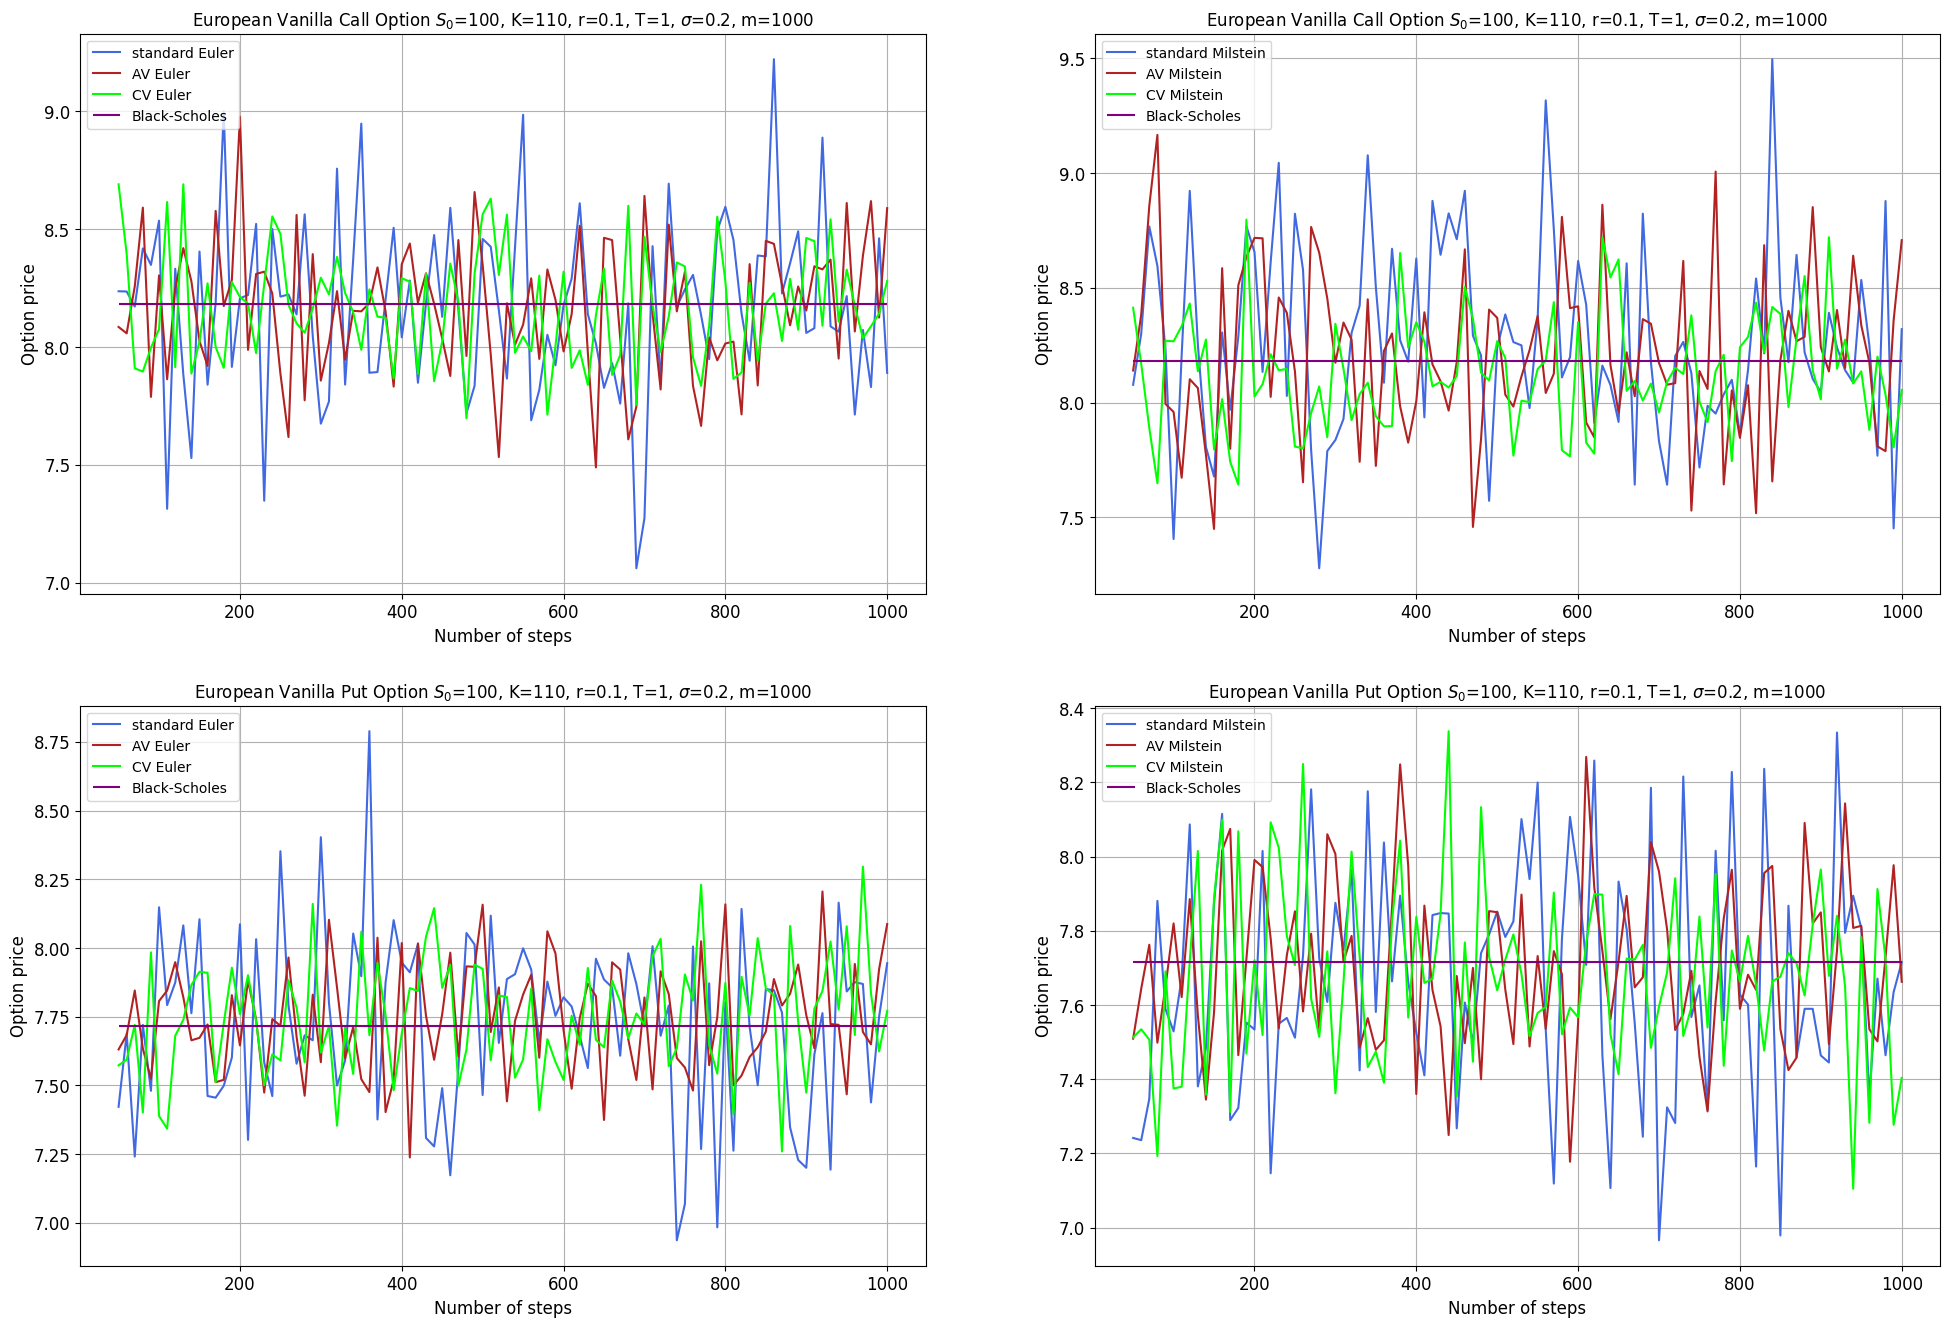

In [5]:
dataframe_var = plot_data_ns(S0, K, r, T, sigma, ms, 'vanilla', ns, full = True)

In [6]:
dataframe_var

,Standard,Antithetic Variates,Control Variates
Euler Call,0.138999,0.077042,0.053014
Milstein Call,0.167126,0.125789,0.058745
Euler Put,0.100844,0.038688,0.041873
Milstein Put,0.095497,0.047323,0.052763


In [7]:
S0, K, r, T, sigma, ms = 100, 100, 0.1, 1, 0.2, 1000

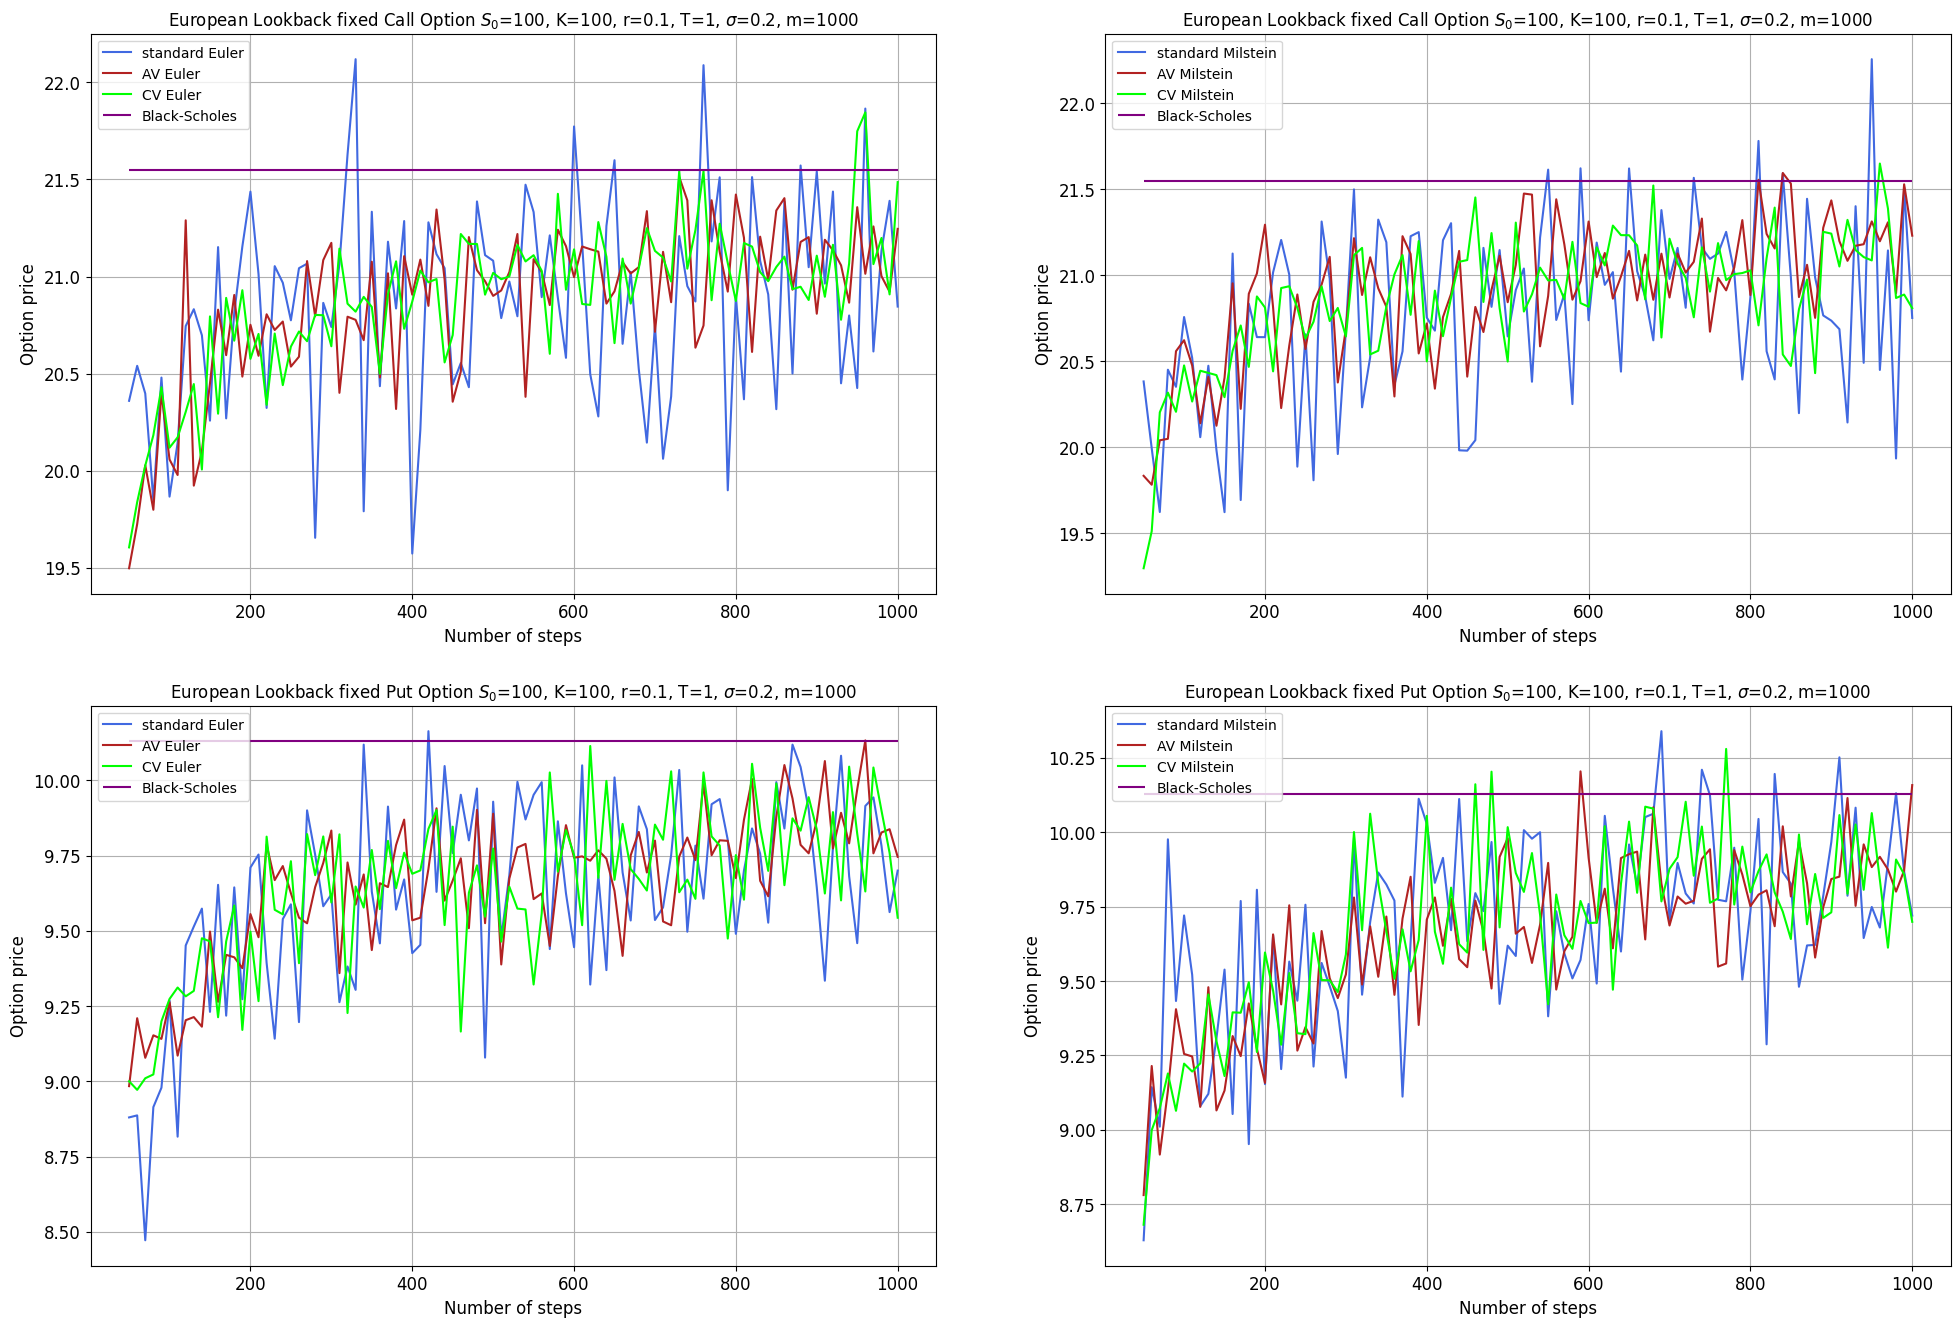

In [8]:
dataframe_var = plot_data_ns(S0, K, r, T, sigma, ms, 'lookback fixed', ns, full = True)

In [9]:
dataframe_var

,Standard,Antithetic Variates,Control Variates
Euler Call,0.269087,0.161714,0.142008
Milstein Call,0.276887,0.149935,0.139205
Euler Put,0.105151,0.055611,0.064180
Milstein Put,0.103582,0.077185,0.085528


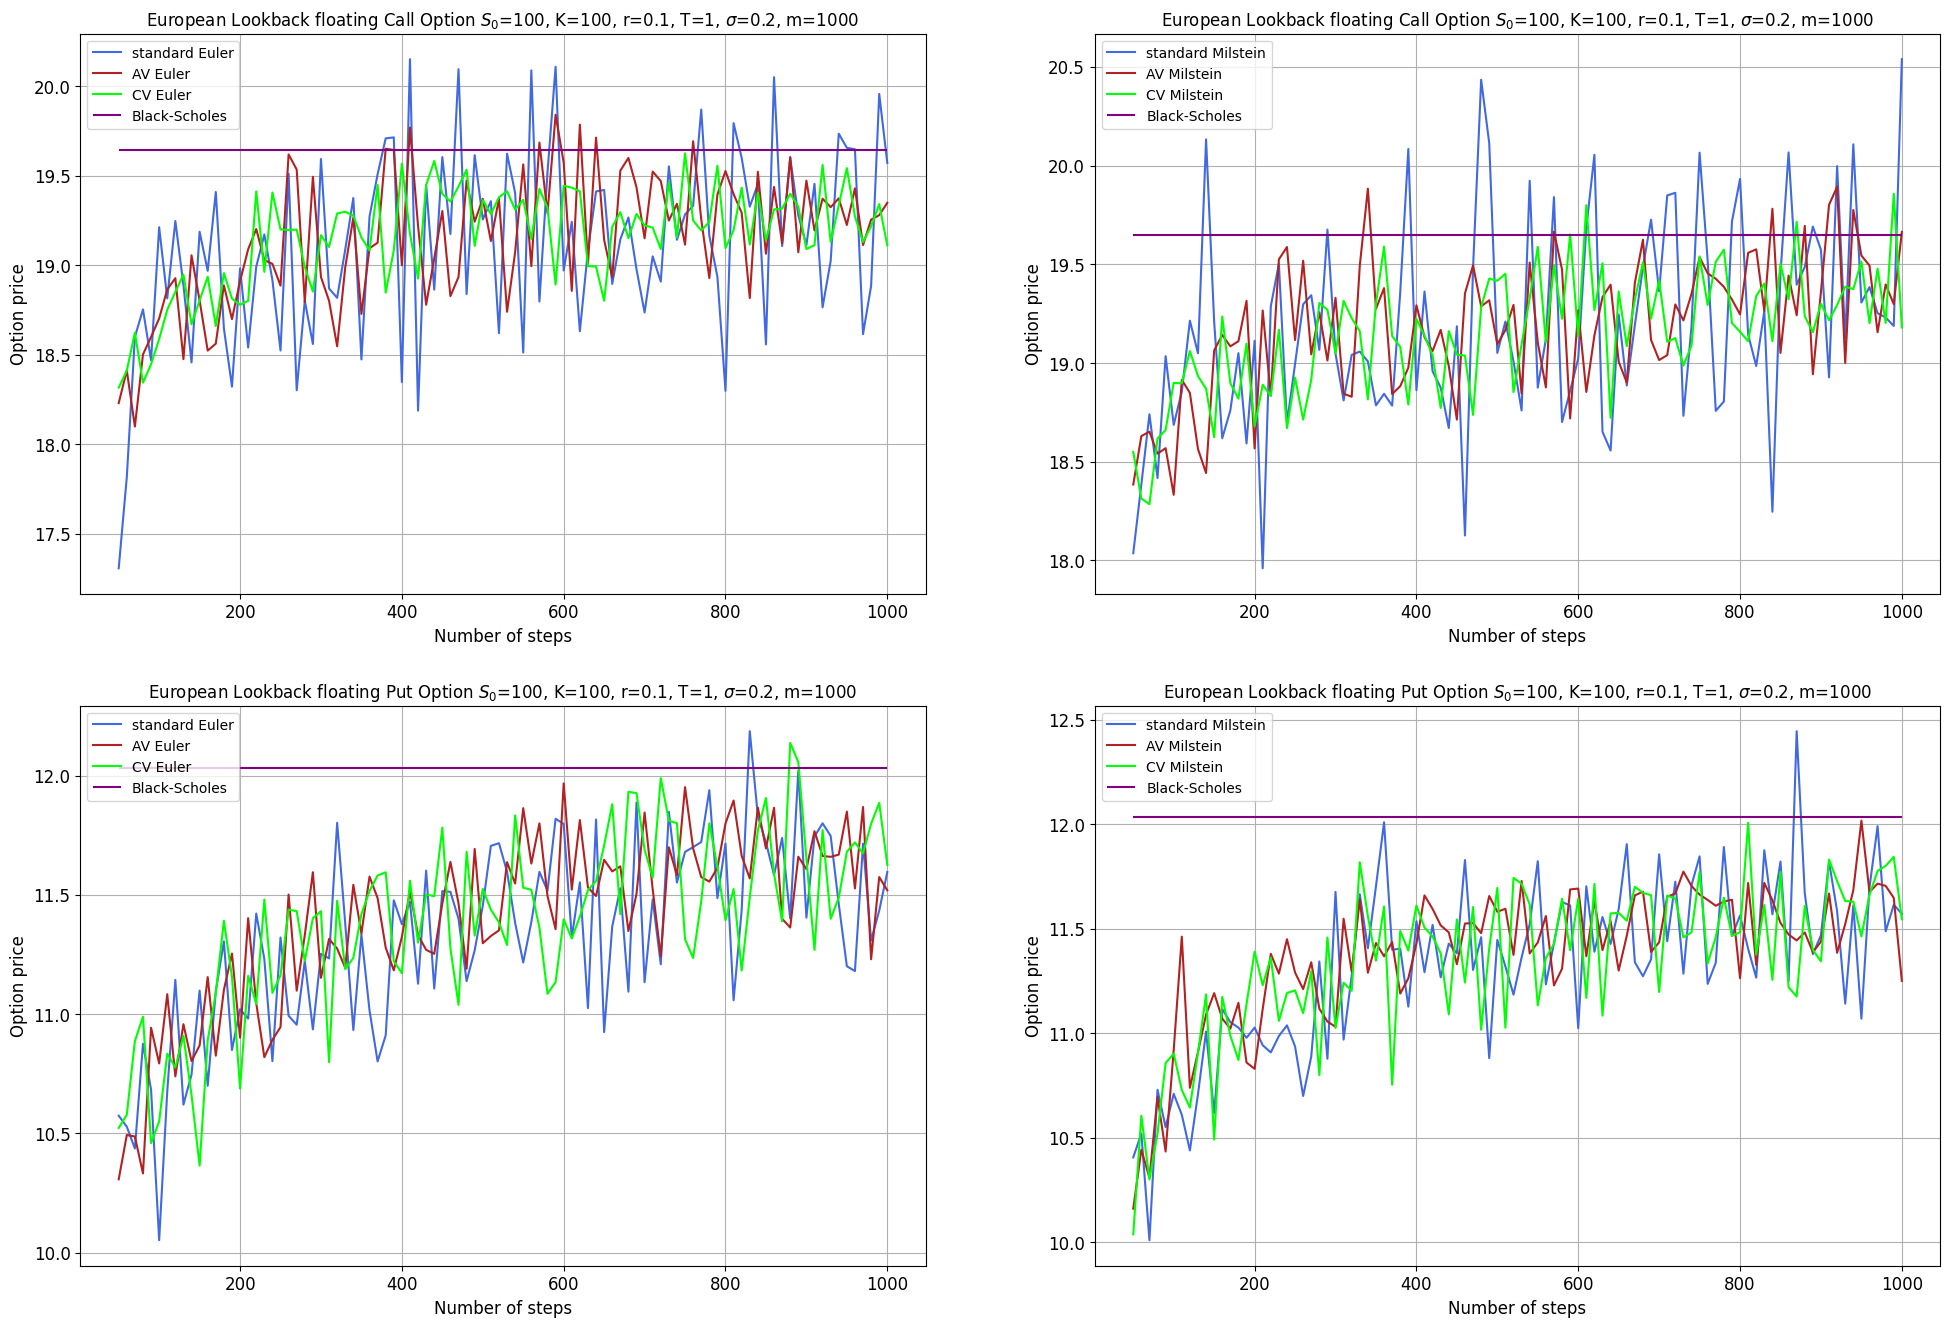

In [10]:
dataframe_var = plot_data_ns(S0, K, r, T, sigma, ms, 'lookback floating', ns, full = True)

In [11]:
dataframe_var

,Standard,Antithetic Variates,Control Variates
Euler Call,0.265600,0.131408,0.081339
Milstein Call,0.266770,0.116372,0.092270
Euler Put,0.151564,0.128344,0.136892
Milstein Put,0.167302,0.108356,0.132437


In [12]:
def create_prices_ms(S0, K, r, T, sigma, ms, option, ns, full = True):
    standard_euler_call = []
    standard_euler_put = []
    AV_euler_call = []
    AV_euler_put = []
    CV_euler_call = []
    CV_euler_put = []
    for m in ms:
        VR = VarianceReduction(S0, K, r, T, sigma, ns, m)
        standard_euler_call.append(VR.calculate_price('standard', 'euler', option, 'call', full))
        standard_euler_put.append(VR.calculate_price('standard', 'euler', option, 'put', full))
        AV_euler_call.append(VR.calculate_price('AV', 'euler', option, 'call', full))
        AV_euler_put.append(VR.calculate_price('AV', 'euler', option, 'put', full))
        CV_euler_call.append(VR.calculate_price('CV', 'euler', option, 'call', full))
        CV_euler_put.append(VR.calculate_price('CV', 'euler', option, 'put', full))
    bs_call, bs_put = VR.black_scholes(option, 'call'), VR.black_scholes(option, 'put')
    data = np.array([standard_euler_call, standard_euler_put, AV_euler_call, AV_euler_put, CV_euler_call, CV_euler_put])
    dataframe_var = pd.DataFrame([[np.var(standard_euler_call), np.var(AV_euler_call), np.var(CV_euler_call)], 
                                [np.var(standard_euler_put), np.var(AV_euler_put), np.var(CV_euler_put)]],
                                columns=['Standard', 'Antithetic Variates', 'Control Variates'], index=['Call', 'Put'])
    return data, bs_call, bs_put, dataframe_var

def plot_data_ms(S0, K, r, T, sigma, ms, option, ns, full = True):
    data, bs_call, bs_put, dataframe_var = create_prices_ms(S0, K, r, T, sigma, ms, option, ns, full)
    fig, axs = plt.subplots(1, 2, figsize=(24, 8))
    vars = ms
    if full == True:
        axs[0].set_title(f'European {option.capitalize()} Call Option Full Trajectory $S_0$={S0}, K={K}, r={r}, T={T}, $\sigma$={sigma}, n={ns}', fontsize=12)
        axs[1].set_title(f'European {option.capitalize()} Put Option Full trajectory $S_0$={S0}, K={K}, r={r}, T={T}, $\sigma$={sigma}, n={ns}', fontsize=12)
    elif full == False:
        axs[0].set_title(f'European {option.capitalize()} Call Option Last Variable $S_0$={S0}, K={K}, r={r}, T={T}, $\sigma$={sigma}, n={ns}', fontsize=12)
        axs[1].set_title(f'European {option.capitalize()} Put Option Last Variable $S_0$={S0}, K={K}, r={r}, T={T}, $\sigma$={sigma}, n={ns}', fontsize=12)
    axs[0].set_xlabel('Simulations', fontsize=12)
    axs[1].set_xlabel('Simulations', fontsize=12)
    axs[0].plot(vars, data[0], label = 'standard Euler', color = 'royalblue')
    axs[0].plot(vars, data[2], label = 'AV Euler', color = 'firebrick')
    axs[0].plot(vars, data[4], label = 'CV Euler', color = 'lime')
    axs[0].hlines(bs_call, xmin=vars[0], xmax=vars[-1], label = 'Black-Scholes', color = 'purple')
    axs[0].set_ylabel('Option price', fontsize=12)
    axs[0].tick_params(axis='x', labelsize=12)
    axs[0].tick_params(axis='y', labelsize=12)
    axs[0].legend(loc = 'upper left')
    axs[0].grid()
    axs[1].plot(vars, data[1], label = 'standard Euler', color = 'royalblue')
    axs[1].plot(vars, data[3], label = 'AV Euler', color = 'firebrick')
    axs[1].plot(vars, data[5], label = 'CV Euler', color = 'lime')
    axs[1].hlines(bs_put, xmin=vars[0], xmax=vars[-1], label = 'Black-Scholes', color = 'purple')
    axs[1].set_ylabel('Option price', fontsize=12)
    axs[1].tick_params(axis='x', labelsize=12)
    axs[1].tick_params(axis='y', labelsize=12)
    axs[1].legend(loc = 'upper left')
    axs[1].grid()
    plt.show()
    return dataframe_var

In [13]:
S0, K, r, T, sigma, ns = 100, 110, 0.1, 1, 0.2, 100
ms = np.arange(100, 10001, 10)

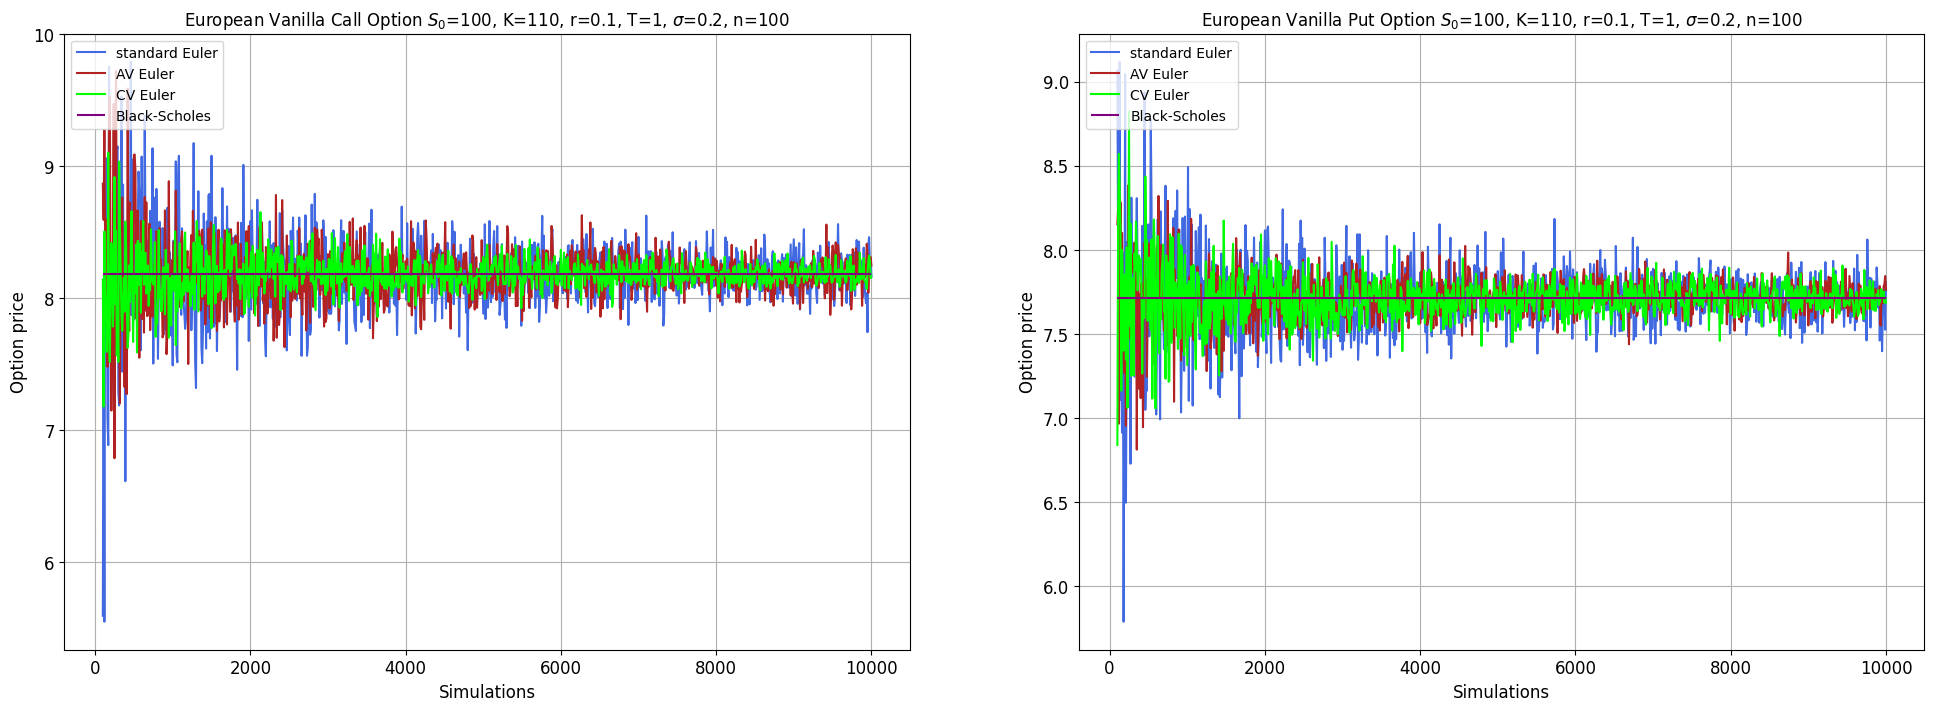

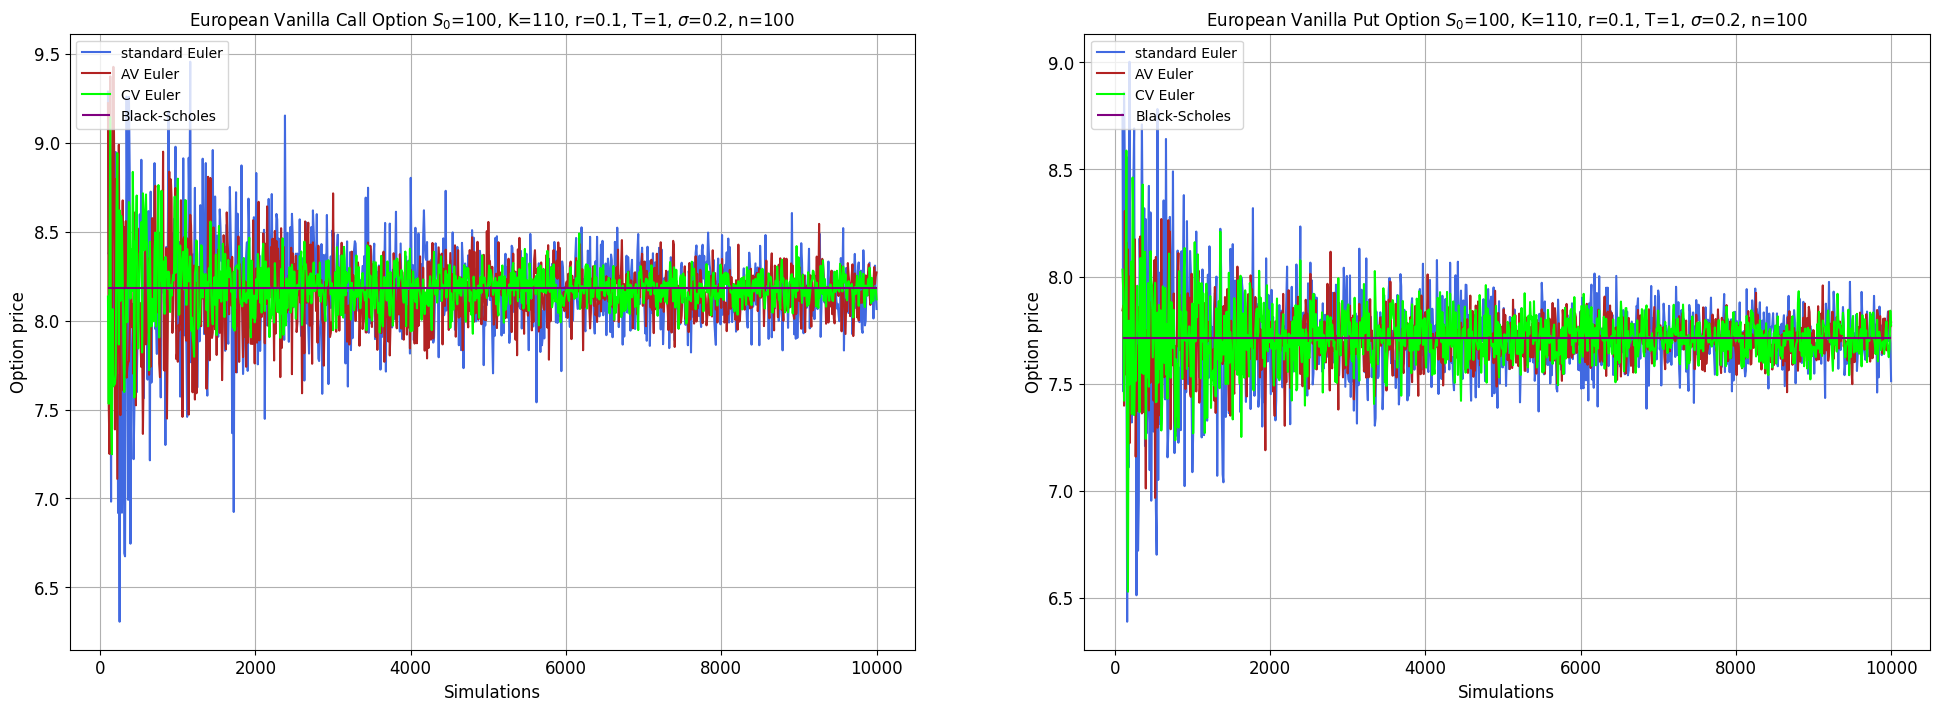

In [14]:
dataframe_var1 = plot_data_ms(S0, K, r, T, sigma, ms, 'vanilla', ns, False) #niepelne trajektorie
dataframe_var2 = plot_data_ms(S0, K, r, T, sigma, ms, 'vanilla', ns, True) #pelne trajektorie

In [15]:
dataframe_var1

,Standard,Antithetic Variates,Control Variates
Call,0.089831,0.054650,0.021425
Put,0.052032,0.018711,0.021210


In [16]:
dataframe_var2

,Standard,Antithetic Variates,Control Variates
Call,0.078836,0.047487,0.021455
Put,0.050814,0.017524,0.019511


In [17]:
S0, K, r, T, sigma, ns = 100, 100, 0.1, 1, 0.2, 100

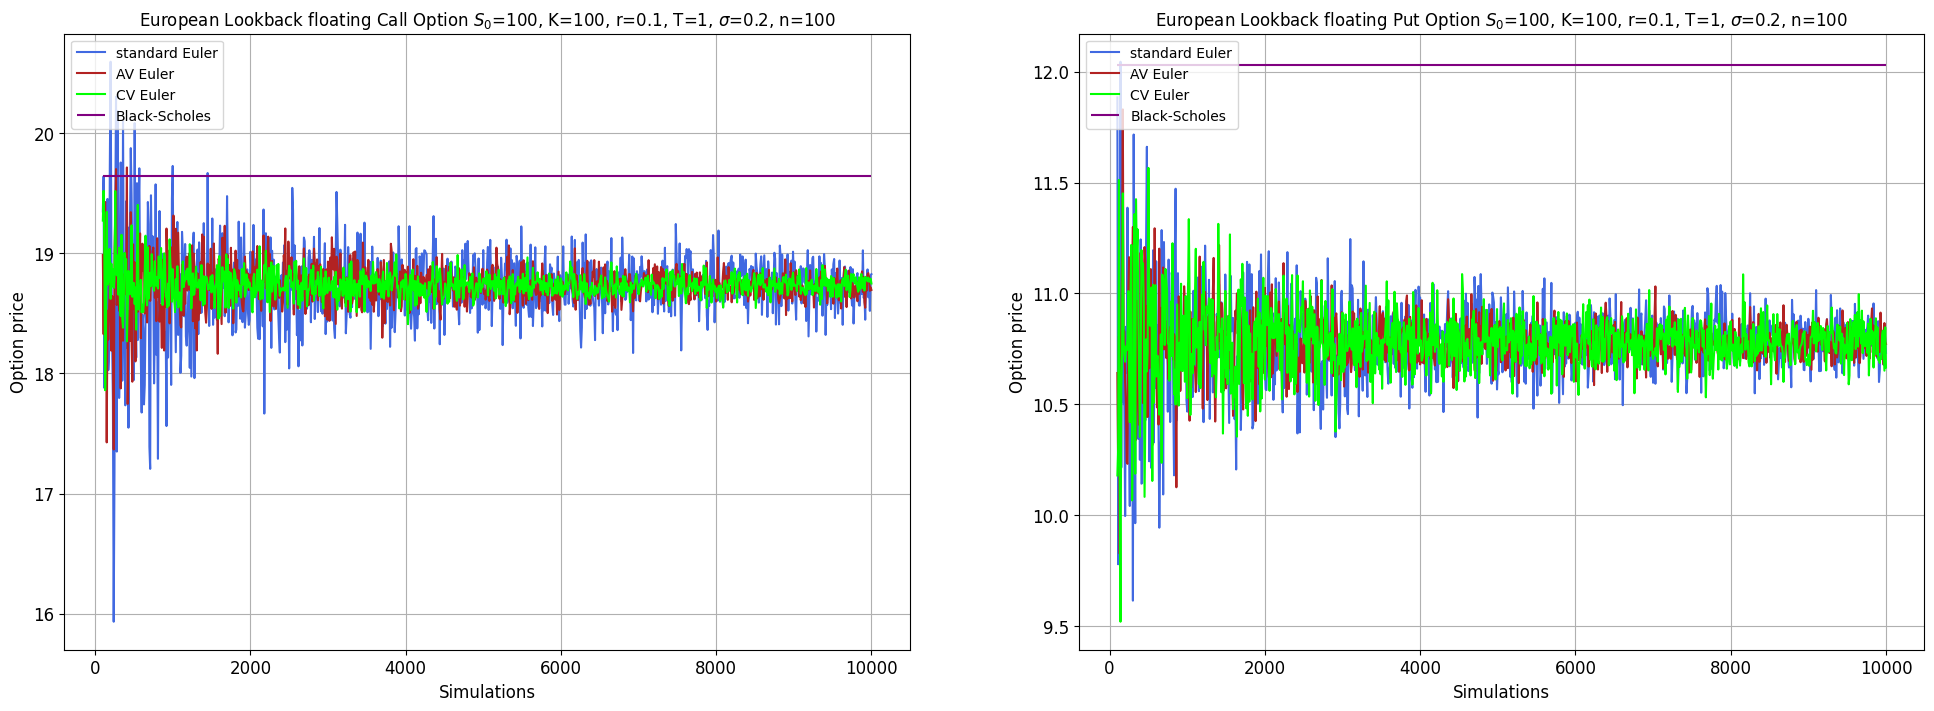

In [18]:
dataframe_var = plot_data_ms(S0, K, r, T, sigma, ms, 'lookback floating', ns, True)

In [19]:
dataframe_var

,Standard,Antithetic Variates,Control Variates
Call,0.109529,0.032227,0.013612
Put,0.037366,0.015987,0.022847


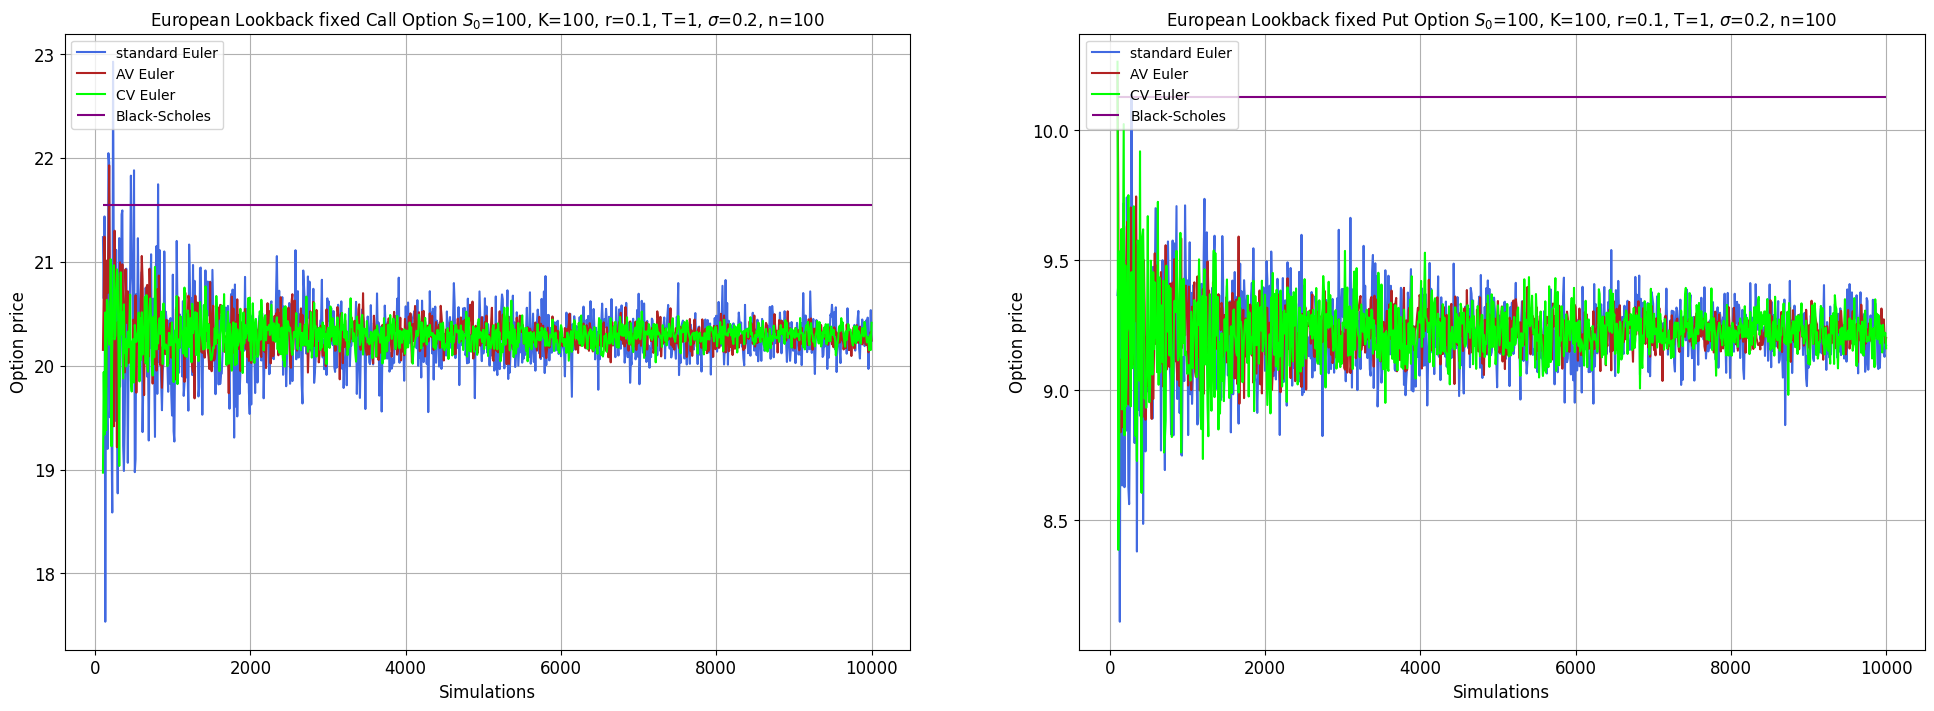

In [20]:
dataframe_var = plot_data_ms(S0, K, r, T, sigma, ms, 'lookback fixed', ns, True)

In [21]:
dataframe_var

,Standard,Antithetic Variates,Control Variates
Call,0.122371,0.033409,0.025843
Put,0.024321,0.010164,0.017726


In [22]:
def plot_bars(S0, K, r, T, sigma, ns, ms, MC, option):
    table = []
    for i in range(MC):
        if i == 0:
            tab, bs_call, bs_put, _ = create_prices_ms(S0, K, r, T, sigma, ms, option, ns, True)
        else:
            tab, _, _, _ = create_prices_ms(S0, K, r, T, sigma, ms, option, ns, True)
        table.append(tab)
    data = np.array(table)
    result = data.transpose(1, 2, 0).swapaxes(0, 1)
    lims = np.zeros((result.shape[0], result.shape[1], 4))
    lims[:,:,0] = np.min(result, axis = 2)
    lims[:,:,1] = np.max(result, axis = 2)
    lims[:,:,2] = np.mean(result, axis = 2) + ss.t.ppf(1-0.05/2, np.sqrt(np.array(ms)[:,np.newaxis])-1) * np.std(result, axis = 2)/np.sqrt(np.array(ms)[:,np.newaxis])
    lims[:,:,3] = np.mean(result, axis = 2) - ss.t.ppf(1-0.05/2, np.sqrt(np.array(ms)[:,np.newaxis])-1) * np.std(result, axis = 2)/np.sqrt(np.array(ms)[:,np.newaxis])
    fig, axs = plt.subplots(1, 2, figsize=(24, 8))
    for i in range(2):
        for k in range(4):
            axs[i].scatter(ms[k], lims[k, i, 2], marker = '_', label = 'standard', color = 'royalblue', zorder = 2, s = 500)
            axs[i].scatter(ms[k], lims[k, i+2, 2], marker = '_', label = 'AV', color = 'firebrick', zorder = 2, s = 500)
            axs[i].scatter(ms[k], lims[k, i+4, 2], marker = '_', label = 'CV', color = 'lime', zorder = 2, s = 500)
            axs[i].scatter(ms[k], lims[k, i, 3], marker = '_', label = 'standard', color = 'royalblue', zorder = 2, s = 500)
            axs[i].scatter(ms[k], lims[k, i+2, 3], marker = '_', label = 'AV', color = 'firebrick', zorder = 2, s = 500)
            axs[i].scatter(ms[k], lims[k, i+4, 3], marker = '_', label = 'CV', color = 'lime', zorder = 2, s = 500)
        if i == 0:
            axs[i].set_title(f'European {option.capitalize()} Call Option $S_0$={S0}, K={K}, r={r}, T={T}, $\sigma$={sigma}, n={ns}', fontsize=12)
            axs[i].hlines(bs_call, xmin=ms[0], xmax=ms[-1], label = 'Black-Scholes', color = 'purple', zorder = 0)
        else:
            axs[i].set_title(f'European {option.capitalize()} Put Option $S_0$={S0}, K={K}, r={r}, T={T}, $\sigma$={sigma}, n={ns}', fontsize=12)
            axs[i].hlines(bs_put, xmin=ms[0], xmax=ms[-1], label = 'Black-Scholes', color = 'purple')
        axs[i].set_ylabel('Option price', fontsize=12)
        axs[i].set_xscale('log')
        axs[i].set_xlabel('Simulations', fontsize=12)
        axs[i].tick_params(axis='x', labelsize=12)
        axs[i].tick_params(axis='y', labelsize=12)
        axs[i].legend(loc = 'upper right')
        axs[i].grid()
    plt.show()

In [23]:
S0, K, r, T, sigma, ns = 100, 110, 0.1, 1, 0.2, 100
ms = np.array([100, 1000, 10000, 100000])

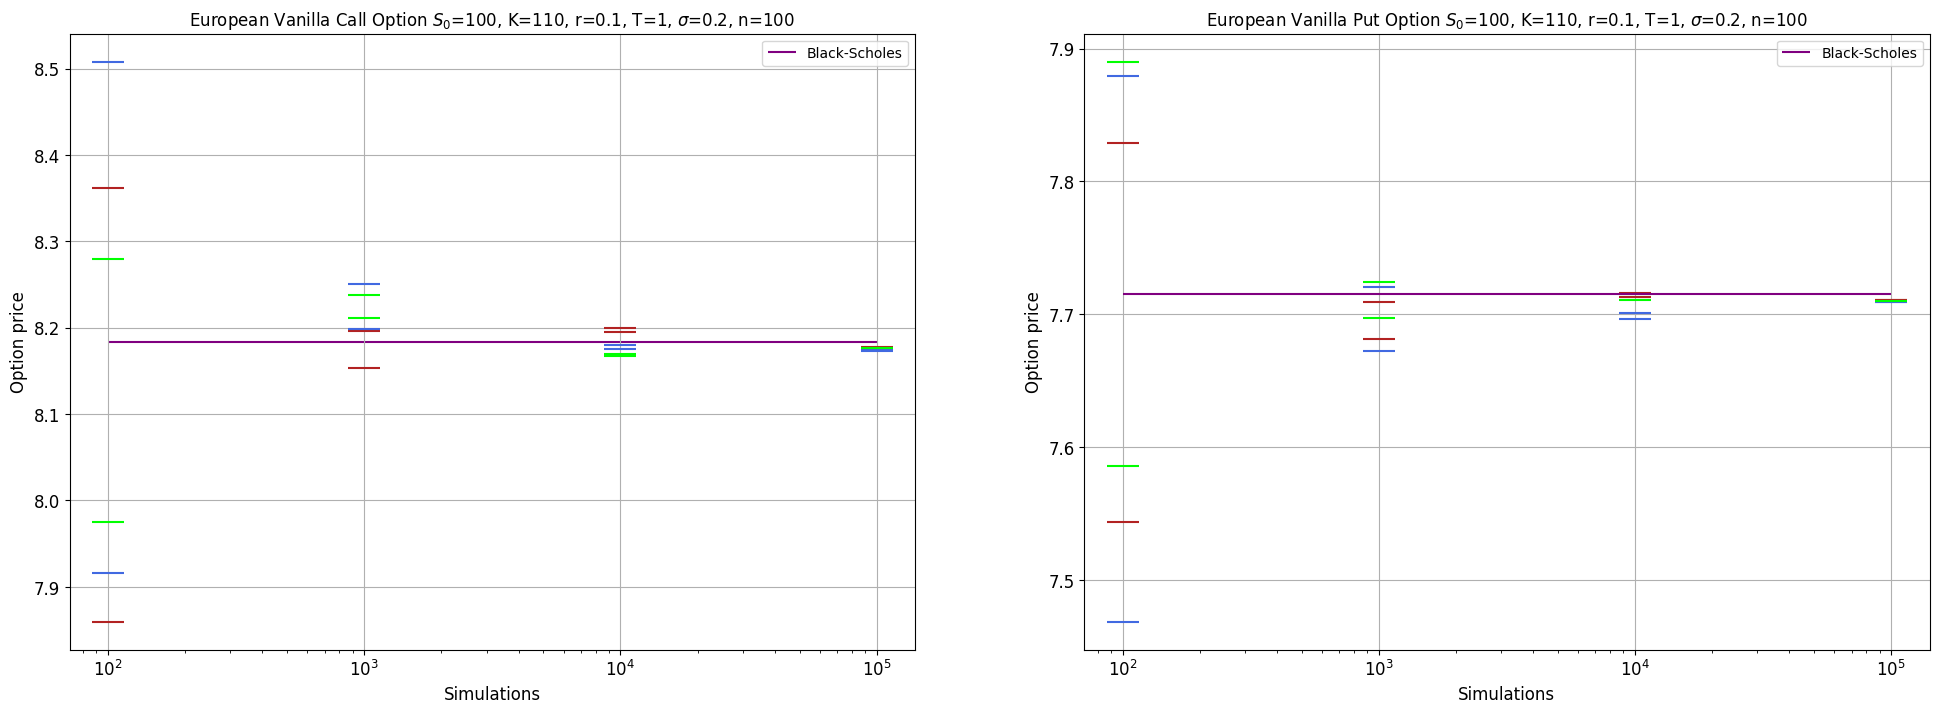

In [24]:
plot_bars(S0, K, r, T, sigma, ns, ms, 100, 'vanilla')

In [25]:
S0, K, r, T, sigma, ns = 100, 100, 0.1, 1, 0.2, 100

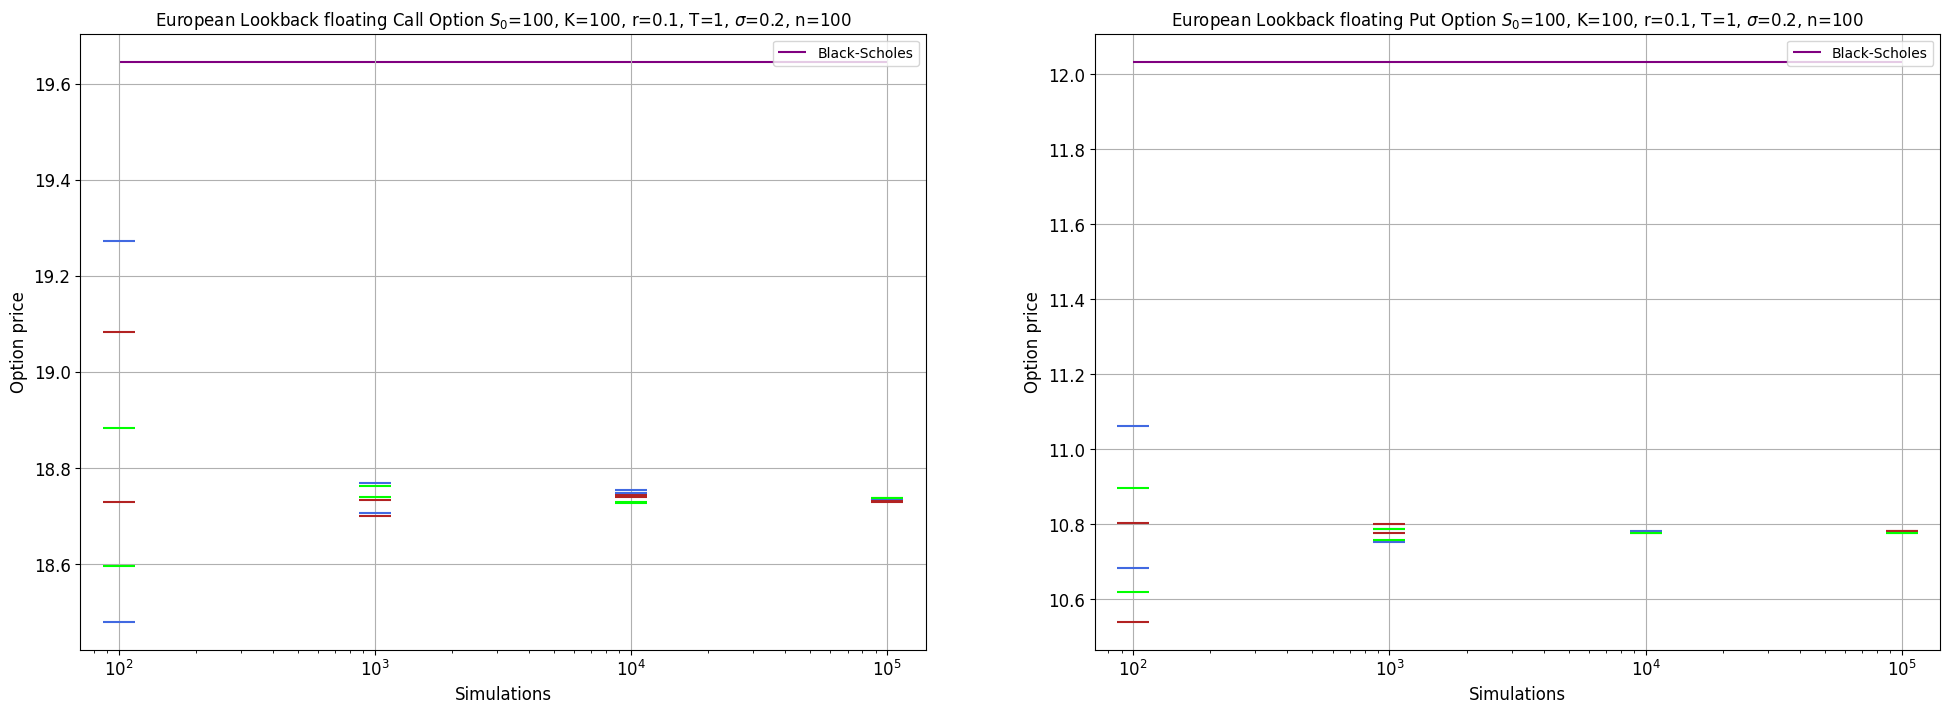

In [26]:
plot_bars(S0, K, r, T, sigma, ns, ms, 100, 'lookback floating')

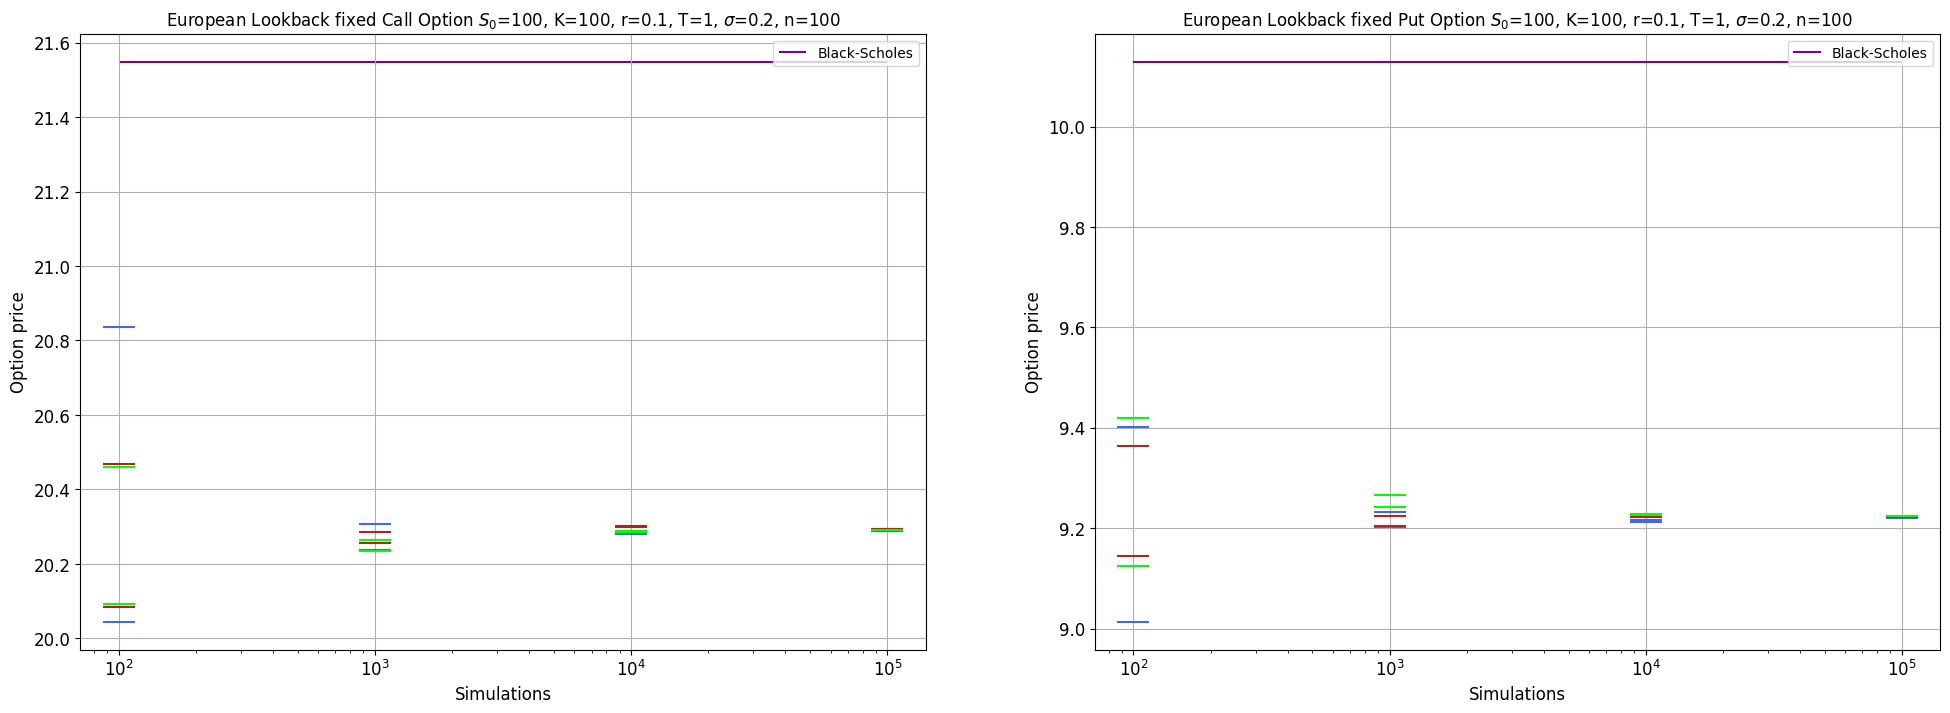

In [27]:
plot_bars(S0, K, r, T, sigma, ns, ms, 100, 'lookback fixed')

Parallelized Monte Carlo Simulation

In [28]:
def trajectory_matrix(S0, r, T, sigma, m, n, method, scheme):
    dt = T/n
    S = np.zeros((m, n + 1))
    S[:, 0] = S0
    Z_ = np.random.normal(0, 1, (int(m/2), n))
    Z = np.zeros((m, n))
    Z[:m // 2, :] = Z_
    if method == 'AV':
        Z[m // 2:, :] = -Z_
    else:
        Z__ = np.random.normal(0, 1, (m // 2, n))
        Z[m // 2:, :] = Z__
    for i in range(1, n + 1):
        if scheme == 'euler':
            S[:, i] = S[:, i-1] * (1 + r * dt + sigma * np.sqrt(dt) * Z[:, i-1])
        elif scheme == 'milstein':
            S[:, i] = S[:, i-1] * (1 + r * dt + sigma * np.sqrt(dt) * Z[:, i-1] + sigma**2/2 * dt * (Z[:, i-1]**2 - 1))
    return S

@njit
def nb_trajectory_matrix(S0, r, T, sigma, m, n, method, scheme):
    dt = T/n
    S = np.zeros((m, n + 1))
    S[:, 0] = S0
    Z_ = np.random.normal(0, 1, (int(m/2), n))
    Z = np.zeros((m, n))
    Z[:m // 2, :] = Z_
    if method == 'AV':
        Z[m // 2:, :] = -Z_
    else:
        Z__ = np.random.normal(0, 1, (m // 2, n))
        Z[m // 2:, :] = Z__
    for i in range(1, n + 1):
        if scheme == 'euler':
            S[:, i] = S[:, i-1] * (1 + r * dt + sigma * np.sqrt(dt) * Z[:, i-1])
        elif scheme == 'milstein':
            S[:, i] = S[:, i-1] * (1 + r * dt + sigma * np.sqrt(dt) * Z[:, i-1] + sigma**2/2 * dt * (Z[:, i-1]**2 - 1))
    return S

In [29]:
S0, K, r, T, sigma, ms, ns = 100, 100, 0.05, 0.5, 0.02, [100, 1000, 10000, 100000], [1000]
starttime = time.time()
for m in ms:
    for n in ns:
        arr = trajectory_matrix(S0, r, T, sigma, m, n, 'standard', 'euler')
endtime = time.time()

print("Monte Carlo trajectory simulations without NUMBA; 1st time: ")
print(endtime-starttime)

starttime = time.time()
for m in ms:
    for n in ns:
        arr = trajectory_matrix(S0, r, T, sigma, m, n, 'standard', 'euler')
endtime = time.time()

print("Monte Carlo trajectory simulations without NUMBA; 2nd time: ")
print(endtime-starttime)

starttime = time.time()
for m in ms:
    for n in ns:
        arr = nb_trajectory_matrix(S0, r, T, sigma, m, n, 'standard', 'euler')
endtime = time.time()

print("Monte Carlo trajectory simulations with NUMBA; 1st time: ")
print(endtime-starttime)

starttime = time.time()
for m in ms:
    for n in ns:
        arr = nb_trajectory_matrix(S0, r, T, sigma, m, n, 'standard', 'euler')
endtime = time.time()

print("Monte Carlo trajectory simulations with NUMBA; 2nd time: ")
print(endtime-starttime)

starttime = time.time()
for m in ms:
    for n in ns:
        arr = nb_trajectory_matrix(S0, r, T, sigma, m, n, 'standard', 'euler')
endtime = time.time()

print("Monte Carlo trajectory simulations with NUMBA; 3rd time: ")
print(endtime-starttime)

Monte Carlo trajectory simulations without NUMBA; 1st time: 
11.10566782951355
Monte Carlo trajectory simulations without NUMBA; 2nd time: 
10.571661472320557
Monte Carlo trajectory simulations with NUMBA; 1st time: 
16.318498849868774
Monte Carlo trajectory simulations with NUMBA; 2nd time: 
9.560717821121216
Monte Carlo trajectory simulations with NUMBA; 3rd time: 
9.497718811035156
